### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'Saccharose hydrolysis'

In [4]:
from_separate_spectra_of_components = False

In [5]:
mixture_path = '../../data/saccharose_1000/all.csv'

reagents_paths = ['../../data/saccharose_1000/sucrose.csv',
                 '../../data/saccharose_1000/glucose.csv',
                '../../data/saccharose_1000/fructose.csv']

reagents_names = ['saccharose', 'glucose', 'fructose']

mixture_separator = '\t'

reagents_separators = ['\t', '\t', '\t']

data_path = '../../data/saccharose_1000/'

#### Mixture in time

In [6]:
mixture_time_data = pd.read_csv(mixture_path, sep = mixture_separator).iloc[:,:-1]

In [7]:
mixture_time_data

,Unnamed: 0,1\nSTANDARD_PROTON_PARAMETERS\n_1,2\nSTANDARD_PROTON_PARAMETERS\n_2,3\nSTANDARD_PROTON_PARAMETERS\n_3,4\nSTANDARD_PROTON_PARAMETERS\n_4,5\nSTANDARD_PROTON_PARAMETERS\n_5,6\nSTANDARD_PROTON_PARAMETERS\n_6,7\nSTANDARD_PROTON_PARAMETERS\n_7,8\nSTANDARD_PROTON_PARAMETERS\n_8,9\nSTANDARD_PROTON_PARAMETERS\n_9,...,1014\nSTANDARD_PROTON_PARAMETERS\n_1014,1015\nSTANDARD_PROTON_PARAMETERS\n_1015,1016\nSTANDARD_PROTON_PARAMETERS\n_1016,1017\nSTANDARD_PROTON_PARAMETERS\n_1017,1018\nSTANDARD_PROTON_PARAMETERS\n_1018,1019\nSTANDARD_PROTON_PARAMETERS\n_1019,1020\nSTANDARD_PROTON_PARAMETERS\n_1020,1021\nSTANDARD_PROTON_PARAMETERS\n_1021,1022\nSTANDARD_PROTON_PARAMETERS\n_1022,1023\nSTANDARD_PROTON_PARAMETERS\n_1023
0,1.53278,-0.000027,0.000041,-0.001069,-0.001475,-0.001056,0.000549,-0.001108,0.000343,-0.001001,...,0.001003,0.000008,0.000409,0.000591,0.000599,-0.000277,0.000593,0.000532,-0.000157,0.000830
1,1.53290,-0.000007,-0.000069,-0.001044,-0.001416,-0.001094,0.000659,-0.001308,0.000357,-0.000934,...,0.000978,-0.000140,0.000493,0.000591,0.000608,-0.000150,0.000798,0.000550,-0.000226,0.000766
2,1.53302,-0.000165,-0.000179,-0.001197,-0.001358,-0.001131,0.000768,-0.001329,0.000371,-0.000866,...,0.000953,-0.000070,0.000576,0.000592,0.000617,-0.000023,0.000643,0.000568,-0.000079,0.000702
3,1.53315,-0.000220,-0.000257,-0.001225,-0.001372,-0.001173,0.000628,-0.001189,0.000327,-0.000848,...,0.000877,0.000148,0.000510,0.000526,0.000568,-0.000080,0.000403,0.000549,0.000073,0.000571
4,1.53327,-0.000098,-0.000334,-0.001074,-0.001565,-0.001214,0.000487,-0.001050,0.000283,-0.000830,...,0.000801,0.000148,0.000443,0.000461,0.000519,-0.000136,0.000380,0.000531,0.000009,0.000656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31840,5.40532,0.013421,0.012783,0.013874,0.013907,0.014093,0.013388,0.013881,0.012687,0.013177,...,0.003162,0.004192,0.003769,0.004087,0.003908,0.003910,0.003110,0.003802,0.002993,0.003231
31841,5.40545,0.013404,0.012786,0.013962,0.013897,0.014070,0.013299,0.013777,0.012716,0.013334,...,0.003118,0.004211,0.003846,0.004088,0.004033,0.004043,0.003137,0.003679,0.002839,0.003182
31842,5.40557,0.013386,0.012790,0.013873,0.013888,0.014048,0.013209,0.013673,0.012745,0.013491,...,0.003075,0.004231,0.003923,0.004090,0.004157,0.004175,0.003165,0.003555,0.002686,0.003133
31843,5.40569,0.013283,0.012810,0.013701,0.013889,0.014100,0.013176,0.013714,0.012766,0.013451,...,0.003191,0.004137,0.003939,0.004052,0.004022,0.004326,0.003078,0.003723,0.002731,0.003214


In [8]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [9]:
mixture_time_data.columns = names

In [10]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    return sp

In [11]:
%matplotlib notebook

<IPython.core.display.Javascript object>


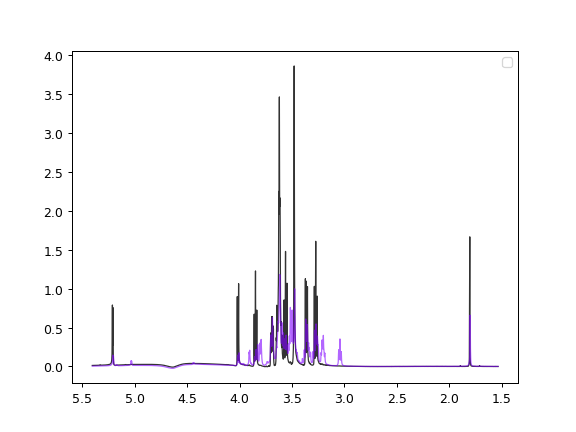

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [12]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all([load_spectrum(mixture_time_data, 1),
                     load_spectrum(mixture_time_data, 1000)], profile=True)

#### Reagents

In [13]:
if from_separate_spectra_of_components:
    
    reagents = []
    for i in range(len(reagents_paths)):
        reagent = pd.read_csv(reagents_paths[i], sep=reagents_separators[i], header=None).iloc[:,:-1]
        reagents.append(reagent)

    reagents_sp = []
    for reagent in reagents:
        ppm = reagent.iloc[:,0]
        ints = reagent.iloc[:,1]
        reagents_sp.append(NMRSpectrum(confs = list(zip(ppm, ints))))
    for sp in reagents_sp:
        sp.normalize()

    reagent0 = reagents[0]
    reagent0 = reagent0[reagent0.iloc[:,0].apply(lambda x: (x>5.2 and x<5.27))]

    reagent1 = reagents[1]
    reagent1 = reagent1[reagent1.iloc[:,0].apply(lambda x: (x>5.05 and x<5.12) or (x>4.52 and x<4.48))]

    reagent2 = reagents[2]
    reagent2 = reagent2[reagent2.iloc[:,0].apply(lambda x: (x>3.8 and x<3.87))]
    
else:
    
    mix1001 = pd.DataFrame(load_spectrum(mixture_time_data, 1001).confs)

    reagent0 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>5.185803 and x<5.246521))]

    reagent1 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>5.013715 and x<5.056501) or (x>4.419116 and x<4.465992))]

    reagent2 = mix1001[mix1001.iloc[:,0].apply(lambda x: (x>3.776692 and x<3.805767))]
    
    reagents = [reagent0, reagent1, reagent2]
    reagents_sp = []
    
    for reagent in reagents:
        ppm = reagent.iloc[:,0]
        ints = reagent.iloc[:,1]
        reagents_sp.append(NMRSpectrum(confs = list(zip(ppm, ints))))
        
    for sp in reagents_sp:
        sp.normalize()

<IPython.core.display.Javascript object>


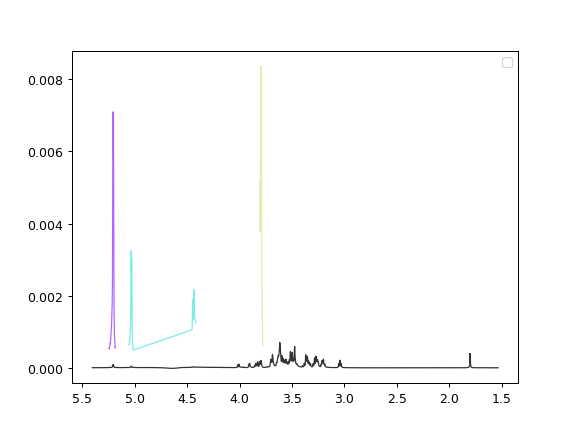

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [14]:
ppm = reagent0.iloc[:,0]
ints = reagent0.iloc[:,1]
sp0 = NMRSpectrum(confs = list(zip(ppm, ints)))
sp0.normalize()

ppm = reagent1.iloc[:,0]
ints = reagent1.iloc[:,1]
sp1 = NMRSpectrum(confs = list(zip(ppm, ints)))
sp1.normalize()

ppm = reagent2.iloc[:,0]
ints = reagent2.iloc[:,1]
sp2 = NMRSpectrum(confs = list(zip(ppm, ints)))
sp2.normalize()

mix_to_plot = load_spectrum(mixture_time_data, 1001)
mix_to_plot.normalize()

plt.gca().invert_xaxis()
NMRSpectrum.plot_all([mix_to_plot, sp0, sp1, sp2], profile=True)

### Saving preprocessed spectra

In [15]:
if from_separate_spectra_of_components:
    np.savetxt(data_path + 'preprocessed_saccharose.csv', reagent0, delimiter = '\t')
    np.savetxt(data_path + 'preprocessed_glucose.csv', reagent1, delimiter = '\t')
    np.savetxt(data_path + 'preprocessed_fructose.csv', reagent2, delimiter = '\t')
else:
    np.savetxt(data_path + 'preprocessed_saccharose_from_mixture.csv', reagent0, delimiter = '\t')
    np.savetxt(data_path + 'preprocessed_glucose_from_mixture.csv', reagent1, delimiter = '\t')
    np.savetxt(data_path + 'preprocessed_fructose_from_mixture.csv', reagent2, delimiter = '\t')